## LOAD DATASET

In [166]:
train_dir = 'Carrot Data/train/'
validation_dir = 'Carrot Data/validation/'

In [167]:
train_fresh = train_dir + 'Fresh'
train_rotten = train_dir + 'Rotten'
validation_fresh = validation_dir + 'Fresh'
validation_rotten = validation_dir + 'Rotten'

In [168]:
import os
train_fresh_names = os.listdir(train_fresh)
train_rotten_names = os.listdir(train_rotten)
validation_fresh_names = os.listdir(validation_fresh)
validation_rotten_names = os.listdir(validation_rotten)


In [169]:
print(len(train_fresh_names))
print(len(train_rotten_names))
print(len(validation_fresh_names))
print(len(validation_rotten_names))

496
464
124
116


## PREPROCESSING DATASET

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#import pandas as pd
import tensorflow.keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [171]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    #featurewise_center=True,
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_data = train_datagen.flow_from_directory(
    train_dir,
    class_mode='categorical',
    target_size=(256, 256),
    batch_size=32
)

Found 960 images belonging to 2 classes.


In [172]:
train_data.class_indices

{'Fresh': 0, 'Rotten': 1}

In [173]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_data = validation_datagen.flow_from_directory(
    validation_dir,
    class_mode='categorical',
    target_size=(256, 256),
    batch_size=16,
    shuffle=False
)

Found 240 images belonging to 2 classes.


In [174]:
validation_data.class_indices

{'Fresh': 0, 'Rotten': 1}

Sample Spinach not fresh image:


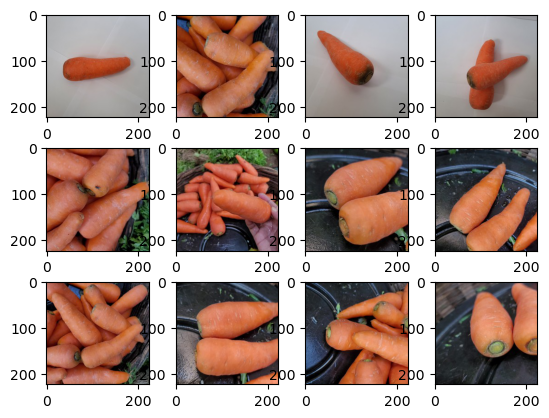

In [175]:
import os
print("Sample Spinach not fresh image:")
train_not_fresh_dir = os.path.join(train_dir, 'Fresh')

for n in range(12):
  plt.subplot(int(12/6)+1, 4, n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(load_img(f"{os.path.join(train_not_fresh_dir, os.listdir(train_not_fresh_dir)[n])}"))
  #plt.axis('off')
plt.show()

Sample Spinach not fresh image:


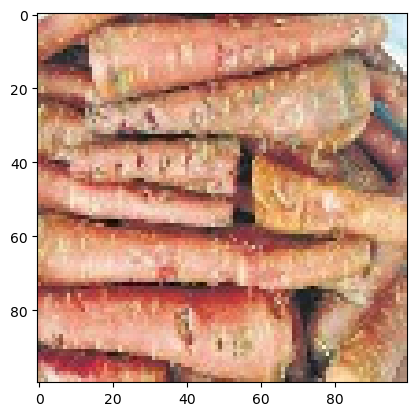

In [176]:
import os
print("Sample Spinach not fresh image:")
train_not_fresh_dir1 = os.path.join(train_dir, 'Rotten')
plt.imshow(load_img(f"{os.path.join(train_not_fresh_dir1, os.listdir(train_not_fresh_dir1)[8])}"))
plt.show()

## BUILDING THE MODEL

In [177]:
base_model = InceptionV3(input_shape=(256,256,3), include_top = False)

In [178]:
for layer in base_model.layers:
  layer.trainable = False

In [179]:
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=2, activation='sigmoid')(x)

#Final model
model = Model(base_model.input, x)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.00001), 
              loss=tensorflow.keras.losses.binary_crossentropy, 
              metrics=['accuracy'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_658 (Conv2D)            (None, 127, 127, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_658 (Batch  (None, 127, 127, 32  96         ['conv2d_658[0][0]']             
 Normalization)                 )                                                           

## CALLBACKs AND TRAINING THE MODEL

In [180]:
from tensorflow.keras.callbacks import Callback

#creates a custom callback class
class CustomCallback(Callback):
    """
    This callback will stop the model from training once the model reaches 95% accuracy on the training data
    """
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.98:
            print('Accuracy above 98% -- Stopping Training')
            self.model.stop_training = True #stops model training

callbacks = CustomCallback()

# Train the model with the custom callback
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=20,
    verbose=1,
    #callbacks=[callbacks]
)


Epoch 1/20
30/30 [==============================] - 64s 2s/step - loss: 0.6418 - accuracy: 0.6906 - val_loss: 0.4485 - val_accuracy: 0.8000
Epoch 2/20
30/30 [==============================] - 57s 2s/step - loss: 0.4258 - accuracy: 0.8177 - val_loss: 0.3487 - val_accuracy: 0.8792
Epoch 3/20
30/30 [==============================] - 57s 2s/step - loss: 0.3724 - accuracy: 0.8417 - val_loss: 0.3240 - val_accuracy: 0.8625
Epoch 4/20
30/30 [==============================] - 59s 2s/step - loss: 0.3106 - accuracy: 0.8750 - val_loss: 0.2654 - val_accuracy: 0.8958
Epoch 5/20
30/30 [==============================] - 59s 2s/step - loss: 0.2739 - accuracy: 0.8990 - val_loss: 0.2384 - val_accuracy: 0.9125
Epoch 6/20
30/30 [==============================] - 60s 2s/step - loss: 0.2607 - accuracy: 0.8938 - val_loss: 0.2321 - val_accuracy: 0.9125
Epoch 7/20
30/30 [==============================] - 60s 2s/step - loss: 0.2650 - accuracy: 0.8969 - val_loss: 0.2177 - val_accuracy: 0.9208
Epoch 8/20
30/30 [==

In [181]:
h = history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Training and validation loss')

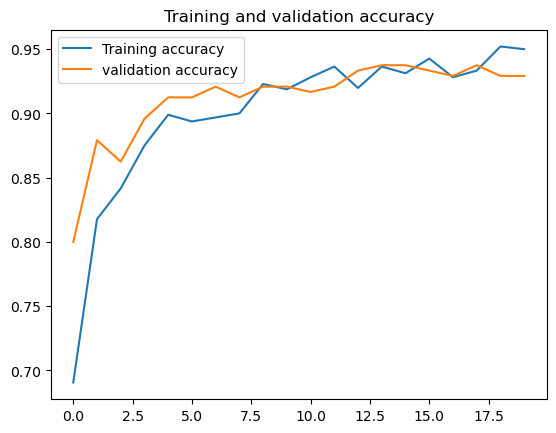

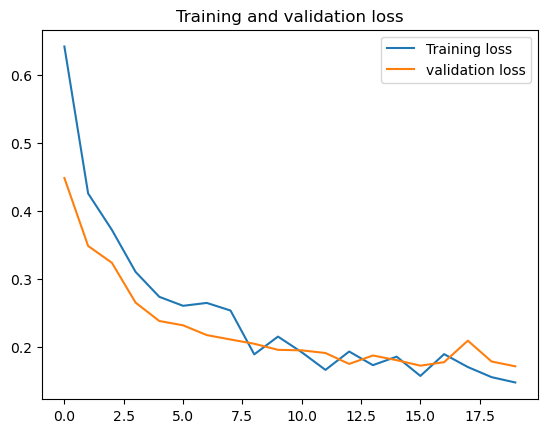

In [182]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc,label="Training accuracy")
plt.plot(epochs, val_acc,label="validation accuracy")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss,label="Training loss")
plt.plot(epochs, val_loss,label="validation loss")
plt.legend()
plt.title('Training and validation loss')


## EVALUATE MODEL

In [183]:
import matplotlib.pyplot as plt
#import numpy
#from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels for test data
y_pred = model.predict(validation_data).argmax(axis=1)  # Predicted labels
y_true = validation_data.classes  # Ground truth labels

cm = confusion_matrix(y_true, y_pred)

cm

15/15 [==============================] - 13s 777ms/step


array([[118,   6],
       [ 11, 105]], dtype=int64)

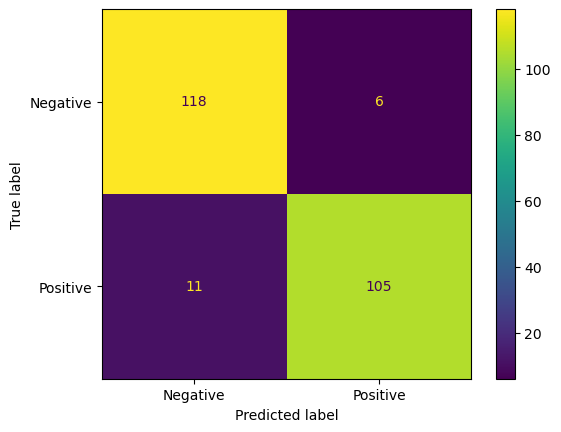

In [184]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Negative', 'Positive'])

cm_display.plot()
plt.show()

In [185]:
def evaluate_model(cm):
  tp = cm[1][1]
  fn = cm[1][0]
  fp = cm[0][1]
  tn = cm[0][0]

  accuracy = (tp+tn)/(tp+fn+fp+tn)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  specificity = tn/(tn+fp)
  f1_score = (2*precision*recall)/(precision+recall)

  return accuracy, precision, recall, specificity, f1_score

accuracy, precision, recall, specificity, f1_score = evaluate_model(cm)
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
#print("Specificity: {:.2f}".format(specificity))
print("F1-Score: {:.4f}".format(f1_score))

Accuracy: 0.9292
Precision: 0.9459
Recall: 0.9052
F1-Score: 0.9251


In [186]:
# Validation from cm
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

#Precision
precision = precision_score(y_true, y_pred)
print("Precision:", precision)

# Recall
recall = recall_score(y_true, y_pred)
print("Recall:", recall)

# F1 Score (which you have already calculated)
f1 = f1_score(y_true, y_pred)
print("F1 Score:", f1)

Accuracy: 0.9291666666666667
Precision: 0.9459459459459459
Recall: 0.9051724137931034
F1 Score: 0.9251101321585904


In [187]:
print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]


## SAVE MODEL IN H5 AND CONVERT TO TFLITE

In [188]:
from keras.models import save_model
save_model(model, 'Model/dropout/do50%.h5')

In [189]:
'''import tensorflow as tf
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

# Save the model.
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)'''

'import tensorflow as tf\n# Convert the model.\nconverter = tf.lite.TFLiteConverter.from_keras_model(model)\ntflite_model = converter.convert()\ntflite_model_file = \'converted_model.tflite\'\n\n# Save the model.\nwith open(tflite_model_file, "wb") as f:\n  f.write(tflite_model)'

## TESTING THE MODEL

In [190]:
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os

def load_images(directory):
    images = {}
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png") or filename.endswith(".webp"):
            path = os.path.join(directory, filename)
            images[filename] = path
    return images

# Specify the directory containing the images
image_directory = "test"

# Call the function to load images and create a dictionary
image_dict = load_images(image_directory)

#load model
model = load_model('Model/dropout/do50%.h5')

for filename, path in image_dict.items():
    # Predicting images
    img = image.load_img(path)#, target_size=(256, 256))
    img = img.resize((256, 256))
    img = image.img_to_array(img)
    img /= 255
    img = np.expand_dims(img, axis=0)

    #img = np.vstack([img])
    classes = model.predict(img, batch_size=20)
    print(filename)
    print(classes)
    output_class = np.argmax(classes)
    classname = ['Fresh', 'Rotten']
    print("The predicted class is", classname[output_class])

1/1 [==============================] - 1s 985ms/step
freshCarrot (1).jpeg
[[0.99653995 0.00287382]]
The predicted class is Fresh
1/1 [==============================] - 0s 142ms/step
freshCarrot (2).jpg
[[0.99922323 0.00456208]]
The predicted class is Fresh
1/1 [==============================] - 0s 141ms/step
freshCarrot (3).png
[[0.7657675  0.14810161]]
The predicted class is Fresh
1/1 [==============================] - 0s 158ms/step
rottenCarrot (1).jpeg
[[0.04961897 0.98623174]]
The predicted class is Rotten
1/1 [==============================] - 0s 142ms/step
rottenCarrot (2).jpg
[[0.00427395 0.9961635 ]]
The predicted class is Rotten
1/1 [==============================] - 0s 157ms/step
rottenCarrot (3).webp
[[0.05037672 0.89052325]]
The predicted class is Rotten
